<a href="https://colab.research.google.com/github/arvindcsekar/GW-PTA-PINN/blob/main/working_multiparam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch    0 | Total: 1.755444e-05 | BC: 0.000000e+00 | Residual: 1.755444e-13
Epoch  100 | Total: 3.283729e-07 | BC: 0.000000e+00 | Residual: 3.283729e-15
Epoch  200 | Total: 3.238536e-08 | BC: 0.000000e+00 | Residual: 3.238536e-16
Epoch  300 | Total: 1.436745e-08 | BC: 0.000000e+00 | Residual: 1.436745e-16
Epoch  400 | Total: 1.141371e-08 | BC: 0.000000e+00 | Residual: 1.141371e-16
Epoch  500 | Total: 1.024988e-08 | BC: 0.000000e+00 | Residual: 1.024988e-16
Epoch  600 | Total: 9.321702e-09 | BC: 0.000000e+00 | Residual: 9.321702e-17
Epoch  700 | Total: 8.354498e-09 | BC: 0.000000e+00 | Residual: 8.354498e-17
Epoch  800 | Total: 7.471268e-09 | BC: 0.000000e+00 | Residual: 7.471268e-17
Epoch  900 | Total: 6.611848e-09 | BC: 0.000000e+00 | Residual: 6.611848e-17
[5.e-07]
[5.6447212e-07]


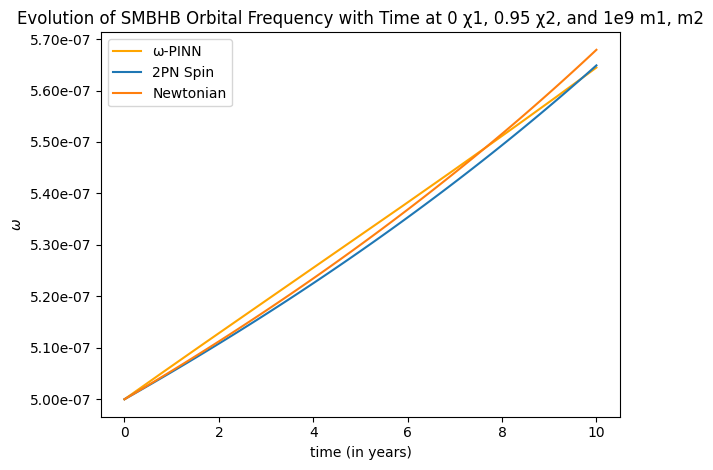

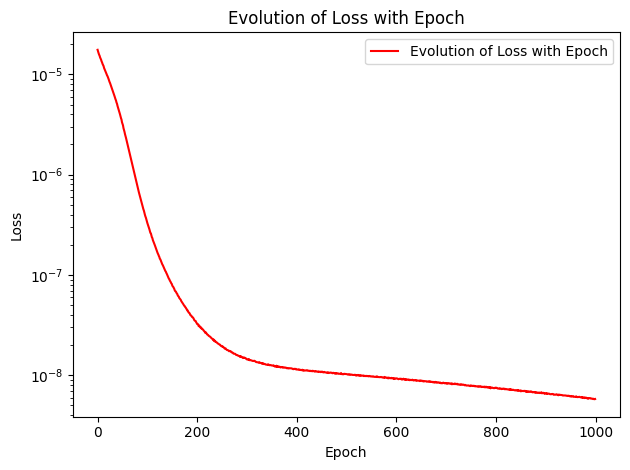

[φ] Epoch 0 | Total 3.569e+11 | BC 6.754e-01 | Resid 2.893e+04
[φ] Epoch 100 | Total 6.651e+10 | BC 1.072e-01 | Resid 5.578e+03
[φ] Epoch 200 | Total 1.149e+10 | BC 1.594e-02 | Resid 9.899e+02
[φ] Epoch 300 | Total 7.430e+09 | BC 1.620e-02 | Resid 5.810e+02
[φ] Epoch 400 | Total 6.059e+09 | BC 8.339e-03 | Resid 5.225e+02
[φ] Epoch 500 | Total 3.220e+09 | BC 9.491e-03 | Resid 2.271e+02
[φ] Epoch 600 | Total 3.399e+09 | BC 7.330e-03 | Resid 2.666e+02
[φ] Epoch 700 | Total 2.729e+09 | BC 6.333e-03 | Resid 2.096e+02
[φ] Epoch 800 | Total 2.703e+09 | BC 1.914e-03 | Resid 2.512e+02
[φ] Epoch 900 | Total 2.781e+09 | BC 1.242e-02 | Resid 1.539e+02


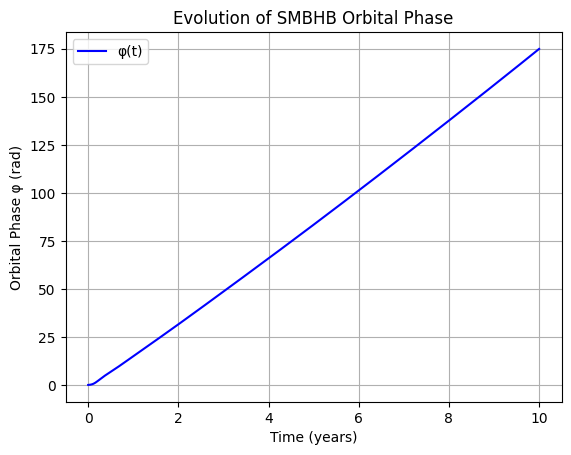

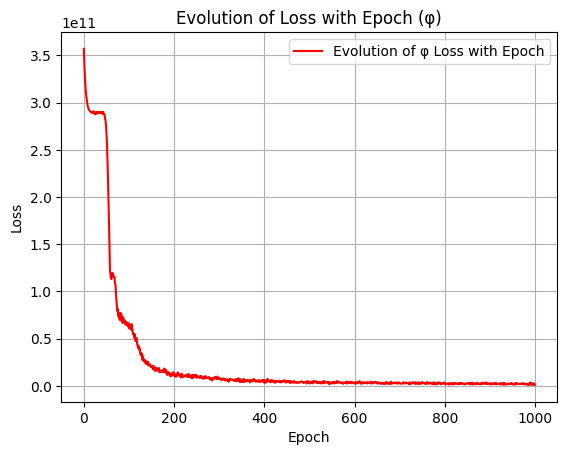

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import torch.nn as nn
import torch.optim as optim
from astropy import units as u
from astropy import constants as ac

torch.manual_seed(42)
np.random.seed(42)

G_SI = ac.G.value #m^3 kg^-1 s^-2
c_SI = ac.c.value #m s^-1
M_sun_SI = ac.M_sun.value #kg

G = torch.tensor(G_SI, dtype=torch.float64)
c = torch.tensor(c_SI, dtype=torch.float64)
t_end = (10 * u.yr).to(u.s).value
t_end_torch = torch.tensor(t_end, dtype=torch.float64)

#normalisation: scale masses by 1e9 Msun
M_scale = 1e9 * M_sun_SI

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1, bias=True)
        )
        self.register_buffer('omega0', torch.tensor(5e-7, dtype=torch.float64))  #baseline near BC
        self.register_buffer('scale',  torch.tensor(1e-6, dtype=torch.float64))
        self.double()

    def forward(self, x):
        z = self.net(x)  #unconstrained
        f = torch.nn.functional.softplus(z) * self.scale  # positive variation
        t = x[:, 0:1]  #normalised time in [0,1]
        omega = self.omega0 + t * f  #hard-enforce BC: omega(tau=0) = omega0
        return omega

def compute_residual_loss(model, num_points):
    t_res = torch.rand(num_points, 1, dtype=torch.float64)
    #need to hard code chi and masses here so network learns exact solution
    chi_1_res = torch.full((num_points, 1), 0, dtype=torch.float64)
    chi_2_res = torch.full((num_points, 1), 0.95, dtype=torch.float64)


    m1_phys = torch.full((num_points, 1), 1e9 * M_sun_SI, dtype=torch.float64)
    m2_phys = torch.full((num_points, 1), 1e9 * M_sun_SI, dtype=torch.float64)


    m1_norm = m1_phys / M_scale
    m2_norm = m2_phys / M_scale

    batch_inputs = torch.cat([t_res, chi_1_res, chi_2_res, m1_norm, m2_norm], dim=1).requires_grad_()

    chi_A = 0.5 * (chi_1_res - chi_2_res)
    chi_S = 0.5 * (chi_1_res + chi_2_res)

    m_total = m1_phys + m2_phys
    eta = (m1_phys * m2_phys) / (m_total**2)
    m_chirp = (eta ** (3.0/5.0)) * m_total

    omega = model(batch_inputs)
    delta = torch.sqrt(torch.clamp(1.0 - 4.0 * eta, min=0.0))
    Q_15 = (-113.0/12.0) * chi_A * delta + (19.0/3.0) * chi_S * eta - (113.0/12.0) * chi_S + 4.0 * torch.pi

    tN_omg = (G * m_chirp * omega) / (c**3)  #dimensionless
    tm_omg = (G * m_total * omega) / (c**3)  #dimensionless

    RHS_t = (96.0/5.0) * (
        1.0
        + ( (59.0/18.0) * (eta**2) + (13661.0/2016.0) * eta + (34103.0/18144.0) ) * (tm_omg ** (4.0/3.0))
        + tm_omg * (Q_15)
        + ( -11.0/4.0 * eta - 743.0/336.0 ) * (tm_omg ** (2.0/3.0))
    ) * (omega**2) * (tN_omg ** (5.0/3.0))

    grads = torch.autograd.grad(
        outputs=omega,
        inputs=batch_inputs,
        grad_outputs=torch.ones_like(omega),
        create_graph=True,
    )[0]
    domega_dtau = grads[:, 0:1]  #derivative wrt t (first column)

    residual = domega_dtau - (t_end_torch * RHS_t)
    residual_loss = torch.mean(residual**2)
    return residual_loss

num_points = 30000
epoch_num = 1000

model = PINN()
optimiser = optim.Adam(model.parameters(), lr=1.7e-4)
loss_MSE = nn.MSELoss()

loss_arr = []

for epoch in range(epoch_num):
    optimiser.zero_grad()

    t_bc = torch.tensor([[0.0]], dtype=torch.float64)
    chi0 = torch.zeros_like(t_bc)
    m0_norm = torch.ones_like(t_bc)

    bc_inputs = torch.cat([t_bc, chi0, chi0, m0_norm, m0_norm], dim=1)
    omg_pred_bc = model(bc_inputs)
    omg_target_bc = torch.tensor([[5e-7]], dtype=torch.float64)
    bc_loss = loss_MSE(omg_pred_bc, omg_target_bc)

    residual_loss = compute_residual_loss(model, num_points)
    w1 = 1
    w2 = 1e8

    total_loss = w1 * bc_loss + w2 * residual_loss
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.2) #adjust norm
    optimiser.step()

    loss_arr.append(total_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Total: {total_loss.item():.6e} | BC: {bc_loss.item():.6e} | Residual: {residual_loss.item():.6e}")

t_values = np.linspace(0.0, 1.0, 1000)
t_tensor = torch.tensor(t_values, dtype=torch.float64).view(-1, 1)

sample_chi1 = torch.full_like(t_tensor, 0, dtype=torch.float64)
sample_chi2 = torch.full_like(t_tensor, 0.95, dtype=torch.float64)
sample_m1_norm = torch.ones_like(t_tensor)
sample_m2_norm = torch.ones_like(t_tensor)

inference_inputs = torch.cat([t_tensor, sample_chi1, sample_chi2, sample_m1_norm, sample_m2_norm], dim=1)
omega_tensor = model(inference_inputs) #physical rad/s

t_years = (t_tensor.detach().numpy() * t_end) / u.yr.to(u.s)
omega_np = omega_tensor.detach().numpy()
print(omega_np[0])
print(omega_np[-1])

plt.figure()
plt.plot(t_years, omega_np, label="Predicted Evolution of SMBHB Orbital Frequency with Time", color="orange")
plt.title("Evolution of SMBHB Orbital Frequency with Time")
plt.xlabel('Time (years)')
plt.ylabel('Orbital Frequency ω (rad/s)')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e'))
plt.legend()
plt.tight_layout()

GMsun = ac.GM_sun.value
c = ac.c.value
dsun = GMsun/(c**2)
tsun = GMsun/(c**3)
pc = ac.pc.value
yr = (365.25)*(24)*(60)*(60)

def get_omg(t,t_a,omg_a,m_c,eta,nu,chi_A,chi_S):
    m=m_c/eta**(3/5)
    tN_ = m_c*omg_a*tsun
    tm_ = m*omg_a*tsun
    tmta_ = t-t_a
    delta=np.sqrt(1-4*eta)
    tau = 1-256/5*omg_a*tN_**(5/3)*tmta_
    Q15=(-113/12*chi_A*delta+19/3*chi_S*eta-113/12*chi_S+4*np.pi)
    ww=(omg_a*(((371/128*eta**2+56975/16128*eta+1855099/903168)/tau**(7/8)+(-3058673/
    1354752-617/192*eta**2-5429/1344*eta)/tau**(11/8)+(-605/192*eta**2-40865/8064*eta-\
    2760245/1354752)/tau**(13/8)+(1331/384*eta**2+89903/16128*eta+6072539/2709504)/
    tau**(19/8))*tm_**(4/3)*nu**2+(3/5/tau**(11/8)*Q15-3/5/tau**(3/4)*Q15)*tm_*nu**(3/2)+
    ((11/8*eta+743/672)/tau**(5/8)+(-11/8*eta-743/672)/tau**(11/8))*tm_**(2/3)*nu+1/
    tau**(3/8)))
    return ww

t=np.linspace(0,10,100)*yr
t_a=0
omg_a= 5e-7
m_c=(1e9**2)**(3/5) / (2*1e9)**(1/5)
eta=1/4
nu=1
chi1 = 0
chi2 = 0.95
chi_A = 0.5*(chi1-chi2)
chi_S = 0.5*(chi1+chi2)
#chi_A ranges from (-0.5,0.5)
#chi_S ranges from (0,1)

omg_arr=get_omg(t,t_a,omg_a,m_c,eta,nu,chi_A,chi_S)
omg_arr_Q=get_omg(t,t_a,omg_a,m_c,eta,0,chi_A,chi_S)

plt.plot(t/yr,omg_arr)
plt.plot(t/yr,omg_arr_Q)
plt.legend(["ω-PINN", "2PN Spin", "Newtonian"])
plt.title("Evolution of SMBHB Orbital Frequency with Time at 0 χ1, 0.95 χ2, and 1e9 m1, m2")
plt.xlabel("time (in years)")
plt.ylabel(r"$\omega$")
plt.show()

plt.figure()
plt.plot(range(epoch_num), loss_arr, label="Evolution of Loss with Epoch", color="red")
plt.title("Evolution of Loss with Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()

plt.show()

class PINN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        self.double()

    def forward(self, t):
        return torch.exp(self.net(t))


def compute_residual_loss_phi(model2, t_batch, model):
    t_pred = t_batch.requires_grad_()
    phi_pred = model2(t_pred)
    dphi_dtau = torch.autograd.grad(phi_pred, t_pred, grad_outputs=torch.ones_like(phi_pred), create_graph=True)[0]

    chi1 = torch.zeros_like(t_pred)
    chi2 = torch.zeros_like(t_pred)
    m1_norm = torch.ones_like(t_pred)
    m2_norm = torch.ones_like(t_pred)

    omega_here = model(torch.cat([t_pred, chi1, chi2, m1_norm, m2_norm], dim=1))

    residual = dphi_dtau - (t_end_torch * omega_here)
    return torch.mean(residual**2)


phi_enforced = torch.tensor([[0.0]], dtype=torch.float64)
model2 = PINN2()
opt_phi = optim.Adam(model2.parameters(), lr=1e-3)
loss_arr_phi = []
w1_phi = 1e11
w2_phi = 1e7

tau_pool = torch.linspace(0.0, 1.0, steps=num_points, dtype=torch.float64).view(-1, 1)

for epoch in range(epoch_num):
    opt_phi.zero_grad()

    bc_inputs2 = torch.tensor([[0.0]], dtype=torch.float64)
    phi_pred_bc = model2(bc_inputs2)
    bc_loss_phi = loss_MSE(phi_pred_bc, phi_enforced)

    idx = torch.randperm(num_points)[:1024]
    tau_batch = tau_pool[idx]
    residual_loss_phi = compute_residual_loss_phi(model2, tau_batch, model)

    total_loss_phi = w1_phi * bc_loss_phi + w2_phi * residual_loss_phi
    total_loss_phi.backward()
    torch.nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
    opt_phi.step()

    loss_arr_phi.append(total_loss_phi.item())
    if epoch % 100 == 0:
        print(f"[φ] Epoch {epoch} | Total {total_loss_phi.item():.3e} | BC {bc_loss_phi.item():.3e} | Resid {residual_loss_phi.item():.3e}")

t_vals = torch.linspace(0, 1, 1000, dtype=torch.float64).view(-1,1)
t_phys = t_vals * t_end_torch
phi_pred = model2(t_vals).detach().numpy()
t_years_phi = (t_phys / u.yr.to(u.s)).detach().numpy()

plt.figure()
plt.plot(t_years_phi, phi_pred, label="φ(t)", color="blue")
plt.xlabel("Time (years)")
plt.ylabel("Orbital Phase φ (rad)")
plt.title("Evolution of SMBHB Orbital Phase")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.plot(range(epoch_num), loss_arr_phi, label = "Evolution of φ Loss with Epoch", color="Red")
plt.title("Evolution of Loss with Epoch (φ)")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()



In [6]:
print("2PN: ", omg_arr[-1])
print("Newtonian: ", omg_arr_Q[-1])
print("omg-PINN: ", omega_np[-1])

2PN:  5.648886938007746e-07
Newtonian:  5.679185605019142e-07
omg-PINN:  [5.6447212e-07]


In [ ]:

class PINN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        self.double()

    def forward(self, t):
        return torch.exp(self.net(t))  # φ(tau) > 0; you can switch to linear if you prefer


def compute_residual_loss_phi(model2, tau_batch, model):
    # tau_batch: [B,1] in [0,1]
    tau_pred = tau_batch.requires_grad_()
    phi_pred = model2(tau_pred)

    # dφ/dτ
    dphi_dtau = torch.autograd.grad(phi_pred, tau_pred, grad_outputs=torch.ones_like(phi_pred), create_graph=True)[0]

    # Build ω-PINN inputs: [tau, chi1, chi2, m1_norm, m2_norm]
    chi1 = torch.zeros_like(tau_pred)  # set your spins here if desired
    chi2 = torch.zeros_like(tau_pred)
    m1_norm = torch.ones_like(tau_pred)  # 1e9 Msun normalized => 1.0
    m2_norm = torch.ones_like(tau_pred)

    omega_here = model(torch.cat([tau_pred, chi1, chi2, m1_norm, m2_norm], dim=1))

    # Residual: dφ/dτ - t_end * ω(τ, ...)
    residual = dphi_dtau - (t_end_torch * omega_here)
    return torch.mean(residual**2)


phi_enforced = torch.tensor([[0.0]], dtype=torch.float64)
model2 = PINN2()
opt_phi = optim.Adam(model2.parameters(), lr=1e-3)
loss_arr_phi = []
w1_phi = 1e7
w2_phi = 1e7

# A proper tau pool to sample from (size matches num_points)
tau_pool = torch.linspace(0.0, 1.0, steps=num_points, dtype=torch.float64).view(-1, 1)

for epoch in range(epoch_num):
    opt_phi.zero_grad()

    # BC at tau=0
    bc_inputs2 = torch.tensor([[0.0]], dtype=torch.float64)
    phi_pred_bc = model2(bc_inputs2)
    bc_loss_phi = loss_MSE(phi_pred_bc, phi_enforced)

    # Sample a batch of tau from the pool
    idx = torch.randperm(num_points)[:1024]
    tau_batch = tau_pool[idx]
    residual_loss_phi = compute_residual_loss_phi(model2, tau_batch, model)

    total_loss_phi = w1_phi * bc_loss_phi + w2_phi * residual_loss_phi
    total_loss_phi.backward()
    torch.nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
    opt_phi.step()

    loss_arr_phi.append(total_loss_phi.item())
    if epoch % 100 == 0:
        print(f"[φ] Epoch {epoch} | Total {total_loss_phi.item():.3e} | BC {bc_loss_phi.item():.3e} | Resid {residual_loss_phi.item():.3e}")

# Evaluate φ(t)
t_vals = torch.linspace(0, 1, 1000, dtype=torch.float64).view(-1,1)
t_phys = t_vals * t_end_torch
phi_pred = model2(t_vals).detach().numpy()
t_years_phi = (t_phys / u.yr.to(u.s)).detach().numpy()

plt.figure()
plt.plot(t_years_phi, phi_pred, label="φ(t)", color="blue")
plt.xlabel("Time (years)")
plt.ylabel("Orbital Phase φ (rad)")
plt.title("Evolution of SMBHB Orbital Phase")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.plot(range(epoch_num), loss_arr_phi, label = "Evolution of φ Loss with Epoch", color="Red")
plt.title("Evolution of Loss with Epoch (φ)")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print("Inference parameters:")
print(f"chi1={sample_chi1[0].item():.3f}, chi2={sample_chi2[0].item():.3f}, m1={float(sample_m1_norm[0].item())*1e9:.3e} Msun, m2={float(sample_m2_norm[0].item())*1e9:.3e} Msun")


Inference parameters:
chi1=0.000, chi2=0.000, m1=1.000e+09 Msun, m2=1.000e+09 Msun


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as ac
import astropy.units as u
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.ticker as ticker

G = ac.G.value #big G constant
c = ac.c.value #light
M_sun = ac.M_sun.value
m = 1e10 * M_sun
nu = 1 #stated
#m_chirp = (eta**(3/5)) * m_total  # kg
#m_c = m_chirp
omg_positive = omg_a = (5e-7 / u.s).to(1/u.s).value
yr = u.yr.to(u.s)
GMsun = ac.GM_sun.value
dsun = GMsun/(c**2)
tsun = GMsun/(c**3)
pc = ac.pc.value
omg_a = (5e-6 / u.s).to(1/u.s).value #from Kepler relation
torch.manual_seed(42)
np.random.seed(42)
G = torch.tensor(ac.G.value, dtype=torch.float64) #big G constant
c = torch.tensor(ac.c.value, dtype=torch.float64) #light
m = 1e9
#m_c = m_chirp = torch.tensor((m**2)**(3/5) / ((2 * m )**(1/5)), dtype=torch.float64)
#m_total = torch.tensor(2*m, dtype=torch.float64) #total mass
nu = torch.tensor(1.0, dtype=torch.float64) #stated


#take t, chi_1, chi_2, m1, m2 as input param
#mass is 1e9 to 1e10 roughly
#eta is 0.1 to 0.25 (aligned)

class PINN(nn.Module):
  def __init__(self):
    super(PINN, self).__init__()
    self.net = nn.Sequential(
      nn.Linear(5, 64), #input 5 neuron (time, chi_1, chi_2, m1, m2), then 64 neurons in each hidden layer
      nn.Tanh(), #activation function
      nn.Linear(64, 64),
      nn.Tanh(),
      nn.Linear(64, 64),
      nn.Tanh(),
      nn.Linear(64, 64),
      nn.Tanh(),
      nn.Linear(64, 1, bias=True) #output layer, 1 neuron (solution, omega)
    )
    self.double() #Ensure the model parameters are of type float64

  def forward(self, x):
    return torch.sigmoid(self.net(x))


num_points = 20000
t_end = (10 * u.yr).to(u.s).value  #10 years in seconds
t_0 = 0
t = torch.rand(num_points, 1, dtype=torch.float64) #b/w t=0 and coalescence time, NORMALISED
chi_1 = torch.rand(num_points, 1, dtype=torch.float64)*2 - 1
chi_2 = torch.rand(num_points, 1, dtype=torch.float64)*2 - 1
m1 = (torch.rand(num_points, 1, dtype=torch.float64) * (1e10 - 1e9) + 1e9) * M_sun
m2 = (torch.rand(num_points, 1, dtype=torch.float64) * (1e10 - 1e9) + 1e9) * M_sun
inputs = torch.cat([t, chi_1, chi_2, m1, m2], dim=1).requires_grad_()

omg_enforced = torch.tensor((5e-7 / u.s).to(1/u.s).value, dtype=torch.float64) #kepler's relation for typical omg value at t=0, with M = 1e9 and R = 0.1pc

t_bc2 = torch.tensor([0.0], dtype=torch.float64).view(-1, 1)
loss_MSE = nn.MSELoss() #mean squared

#weights
w1 = 1e17
w2 = 7

def compute_residual_loss(model, num_points):
    t_residual = (torch.rand(num_points, 1, dtype=torch.float64) * t_end).requires_grad_()
    chi_1_residual = torch.rand(num_points, 1, dtype=torch.float64)*2 - 1
    chi_2_residual = torch.rand(num_points, 1, dtype=torch.float64)*2 - 1
    m1_residual = torch.rand(num_points, 1, dtype=torch.float64)*(1e10 - 1e9) + 1e9
    m2_residual = torch.rand(num_points, 1, dtype=torch.float64)*(1e10 - 1e9) + 1e9
    m1_residual = m1_residual * M_sun
    m2_residual = m2_residual * M_sun

    batch_inputs = torch.cat([t_residual/t_end, chi_1_residual, chi_2_residual, m1_residual, m2_residual], dim=1).requires_grad_()
    chi_A_residual = 0.5*(chi_1_residual - chi_2_residual)
    chi_S_residual = 0.5*(chi_1_residual + chi_2_residual)
    eta_residual = m1_residual*m2_residual/((m1_residual+m2_residual)**2)
    m_total = m1_residual + m2_residual
    m_chirp = (m1_residual*m2_residual)**(3/5) / (m_total**(1/5))
    tsun = GMsun/(c**3)
    delta = torch.sqrt(1-4*eta_residual)

    Q_15 = (-113/12 * chi_A_residual * delta + 19/3 * chi_S_residual * eta_residual - 113/12 * chi_S_residual + 4*np.pi)

    omg_pred = model(batch_inputs)

    tN_omg = (G * m_chirp * omg_pred / (c**3))
    tm_omg = (G * m_total * omg_pred / (c**3))

    domg_dt = torch.autograd.grad(
        outputs=omg_pred,
        inputs=t_residual,
        grad_outputs=torch.ones_like(omg_pred),
        create_graph=True
    )[0]/t_end

    rhs = (96/5) * (
        1
        + (59/18*eta_residual**2 + 13661/2016*eta_residual + 34103/18144) * tm_omg**(4/3) * nu**2
        + (-11/4*eta_residual - 743/336) * tm_omg**(2/3) * nu
        + Q_15 * tm_omg * nu**(3/2)
    ) * (omg_pred**2) * (tN_omg**(5/3))

    residual = domg_dt - rhs
    residual_loss = torch.mean(residual**2)
    return residual_loss


model = PINN()
optimiser = optim.Adam(model.parameters(), lr=1e-3) #Adam optimiser w learning rate

epoch_num = 500
loss_arr = []
for epoch in range(epoch_num):
  optimiser.zero_grad() #clears old grads

  bc_input = torch.tensor([[0.0, 0.0, 0.0, 1e9 * M_sun, 1e9 * M_sun]], dtype=torch.float64)
  omg_pred_bc2 = model(bc_input)
  omg_target_bc2 = omg_enforced.view(-1,1)

  bc_loss = loss_MSE(omg_pred_bc2, omg_target_bc2)
  residual_loss = compute_residual_loss(model, num_points)

  omg_pred = model(inputs)

  total_loss = w1 * bc_loss + w2 * residual_loss
  total_loss.backward() #back propagation, calculates how much weights should change
  torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
  loss_arr.append(total_loss.item())
  optimiser.step() #updates weights using gradients computed in back propagation

  if epoch % 100 == 0:
        print(f"Epoch {epoch} | Total: {total_loss.item():.5f} | BC: {bc_loss.item():.5f} | Residual: {residual_loss.item():.5f}")

t_values = np.linspace(0, 1, 1000) #normalised
chi_1_values = np.linspace(-1, 1, 1000)
chi_2_values = np.linspace(-1, 1, 1000)
m1_values = np.linspace(1e9, 1e10, 1000)
m2_values = np.linspace(1e9, 1e10, 1000)
#eta_values = np.linspace(0.1, 0.25, 1000)


t_tensor = torch.tensor(t_values, dtype=torch.float64).view(-1, 1)
t_tensor_upscale = t_tensor * t_end #upscale

sample_chi1 = torch.zeros_like(t_tensor)
sample_chi2 = torch.zeros_like(t_tensor)
sample_m1 = torch.ones_like(t_tensor) * (1e9 * M_sun)
sample_m2 = torch.ones_like(t_tensor) * (1e9 * M_sun)

new_inputs = torch.cat([t_tensor, sample_chi1, sample_chi2, sample_m1, sample_m2], dim=1).requires_grad_()
omg_tensor = model(new_inputs)

t_np = (t_tensor_upscale / u.yr.to(u.s)).detach().numpy() #converting back
omg_np = omg_tensor.detach().numpy()

plt.plot(t_np, omg_np, label="Predicted Evolution of SMBHB Orbital Frequency with Time", color="orange")
plt.title("Evolution of SMBHB Orbital Frequency with Time")
plt.xlabel('Time (years)')
plt.ylabel('Orbital Frequency ω (rad/s)')
plt.legend()
plt.show()

plt.plot(range(epoch_num), loss_arr, label = "Evolution of Loss with Epoch", color="Red")
plt.title("Evolution of Loss with Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

ValueError: module functions cannot set METH_CLASS or METH_STATIC

space

In [ ]:
class PINN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        self.double()

    def forward(self, t):
        return torch.exp(self.net(t))

def compute_residual_loss_phi(model2, t_batch, model):
    t_pred = t_batch.requires_grad_()
    phi_pred = model2(t_pred)

    chi_A_zero = torch.zeros_like(t_pred)
    chi_S_zero = torch.zeros_like(t_pred)
    dphi_dtau = torch.autograd.grad(phi_pred, t_pred, grad_outputs=torch.ones_like(phi_pred), create_graph=True)[0]
    omega_here = model(torch.cat([t_pred, chi_A_zero, chi_S_zero], dim=1))

    residual = dphi_dtau - omega_here * t_end
    return torch.mean(residual**2)

phi_enforced = torch.tensor([[0.0]], dtype=torch.float64)
model2 = PINN2()
opt_phi = optim.Adam(model2.parameters(), lr=1e-3)
loss_arr_phi = []
w1 = w2 = 1e7

for epoch in range(epoch_num):
    opt_phi.zero_grad()
    phi_pred_bc = model2(t_bc2)
    bc_loss = loss_MSE(phi_pred_bc, phi_enforced)

    idx = torch.randperm(num_points)[:1024]
    t_batch = t[idx]
    residual_loss = compute_residual_loss_phi(model2, t_batch, model)

    total_loss = w1 *bc_loss + w2 * residual_loss
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
    opt_phi.step()

    loss_arr_phi.append(total_loss.item())
    if epoch % 100 == 0:
        print(f"[φ] Epoch {epoch} | Total {total_loss.item():.3e} | BC {bc_loss.item():.3e} | Resid {residual_loss.item():.3e}")

t_vals = torch.linspace(0, 1, 1000, dtype=torch.float64).view(-1,1)
t_phys = t_vals * t_end

phi_pred = model2(t_vals).detach().numpy()

t_years = (t_phys / u.yr.to(u.s)).detach().numpy()


plt.plot(t_years, phi_pred, label="φ(t)", color="blue")
plt.xlabel("Time (years)")
plt.ylabel("Orbital Phase φ (rad)")
plt.title("Evolution of SMBHB Orbital Phase")
plt.grid()
plt.legend()
plt.show()

plt.plot(range(epoch_num), loss_arr_phi, label = "Evolution of Loss with Epoch", color="Red")
plt.title("Evolution of Loss with Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.grid()
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x3 and 5x64)

In [ ]:

t_plot_n = 60
chi1_plot_n = 60
chi2_plot_n = 60

t_values_plot = np.linspace(0, 1, t_plot_n)
chi_1_values_plot = np.linspace(-1, 1, chi1_plot_n)
chi_2_values_plot = np.linspace(-1, 1, chi2_plot_n)

T, A, S = torch.meshgrid(
    torch.tensor(t_values_plot, dtype=torch.float64),
    torch.tensor(chi_1_values_plot, dtype=torch.float64),
    torch.tensor(chi_2_values_plot, dtype=torch.float64),
    indexing='ij'
)

grid = torch.cat([T.reshape(-1,1), A.reshape(-1,1), S.reshape(-1,1)], dim=1)

with torch.no_grad():
    omg_vals = model(grid).squeeze()

omg_vals = omg_vals.reshape(T.shape)

fig = go.Figure(data=go.Isosurface(
    x=T.flatten(),
    y=A.flatten(),
    z=S.flatten(),
    value=omg_vals.flatten(),
    isomin=omg_vals.min().item(),
    isomax=omg_vals.max().item(),
    surface_count=8,  #number of contour surfaces
    colorscale="Viridis", #cleaner edges
))

fig.update_layout(scene=dict(
    xaxis_title='t (normalized)',
    yaxis_title='chi_1',
    zaxis_title='chi_2'
))
fig.show()

t_plot_n = 60
chiA_plot_n = 60
chiS_plot_n = 60

t_values_plot = np.linspace(0, 1, t_plot_n)
chi_A_values_plot = np.linspace(-0.5, 0.5, chiA_plot_n)
chi_S_values_plot = np.linspace(0, 1, chiS_plot_n)

T, A, S = torch.meshgrid(
    torch.tensor(t_values_plot, dtype=torch.float64),
    torch.tensor(chi_A_values_plot, dtype=torch.float64),
    torch.tensor(chi_S_values_plot, dtype=torch.float64),
    indexing='ij'
)

grid = torch.cat([T.reshape(-1,1), A.reshape(-1,1), S.reshape(-1,1)], dim=1)

with torch.no_grad():
    omg_vals = model(grid).squeeze()

omg_vals = omg_vals.reshape(T.shape)

fig = go.Figure(data=go.Isosurface(
    x=T.flatten(),
    y=A.flatten(),
    z=S.flatten(),
    value=omg_vals.flatten(),
    isomin=omg_vals.min().item(),
    isomax=omg_vals.max().item(),
    surface_count=8,  #number of contour surfaces
    colorscale="Viridis", #cleaner edges
))

fig.update_layout(scene=dict(
    xaxis_title='t (normalized)',
    yaxis_title='chi_A',
    zaxis_title='chi_S'
))
fig.show()
